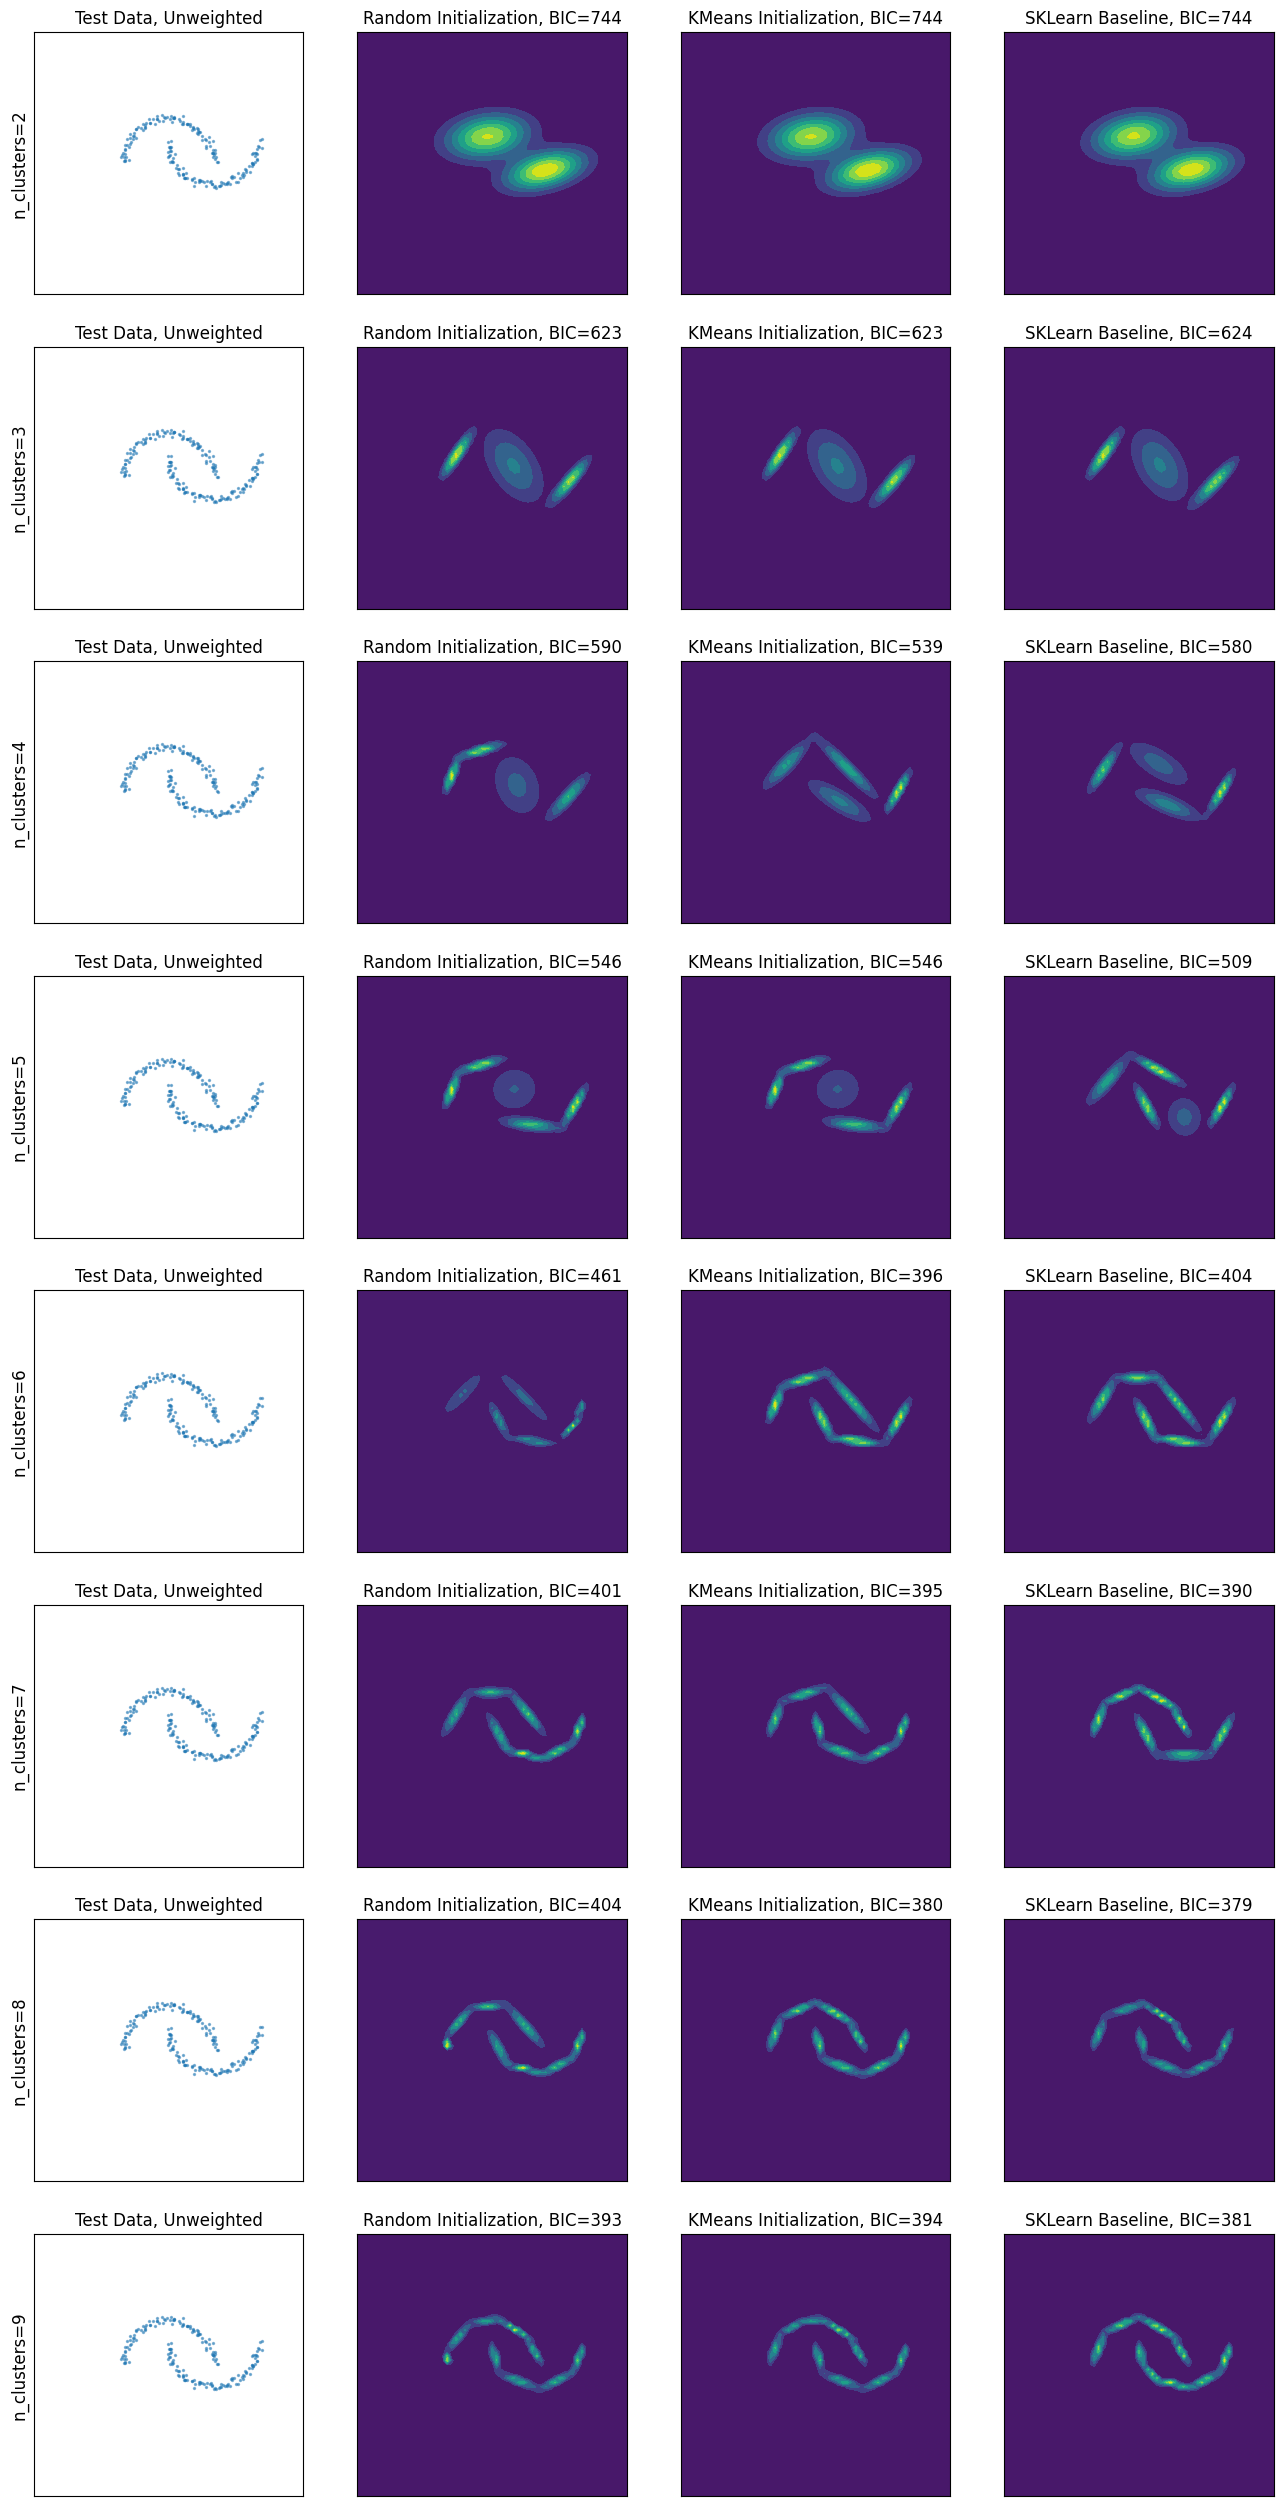

In [1]:
import importlib
import clustering
importlib.reload(clustering)
from clustering import perform_gmm_weighted, compute_aic_bic_pomegranate
import numpy as np

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import Normal


import sklearn
import sklearn.datasets 
import numpy as np

#-------------------------------------------------------------------------------
#Get data from somewhere (moons data is nice for examples)
Xmoon, ymoon = sklearn.datasets.make_moons(200, shuffle = False, noise=.05, random_state=0)
Moon1 = Xmoon[:100] 
Moon2 = Xmoon[100:] 
MoonsDataSet = Xmoon

#Weight the data from moon2 much higher than moon1:
MoonWeights = np.array([np.ones(100), np.ones(100)]).flatten()


x = np.arange(-3, 3.1, .1)
y = np.arange(-3, 3.1, .1)

xx, yy = np.meshgrid(x, y)
x_ = np.array(list(zip(xx.flatten(), yy.flatten())))
np.random.seed(42)



n_clusters_range = np.arange(2, 10)

fig, all_axes = plt.subplots(n_clusters_range.shape[0], 4, figsize=(16, 4 * n_clusters_range.shape[0]))

for i, n_clusters in enumerate(n_clusters_range):

    model_random_init = GeneralMixtureModel(
        [Normal() for _ in range(n_clusters)],
        tol=1e-3,
        verbose=0)
    model_random_init.fit(
        X=MoonsDataSet.astype(np.float32)
    )

    model = perform_gmm_weighted(MoonsDataSet, n=n_clusters, weights=MoonWeights)

    p_kmeans_init = model.probability(x_).reshape(len(x), len(y))
    p_rand_init = model_random_init.probability(x_).reshape(len(x), len(y))

    
    axes = all_axes[i, :]
    axes[0].set_title("Test Data, Unweighted", fontsize=12)
    axes[0].scatter(MoonsDataSet[:, 0], MoonsDataSet[:, 1], s=2, alpha=0.5)


    axes[1].set_title(f"Random Initialization, BIC={compute_aic_bic_pomegranate(model_random_init, MoonsDataSet)[1]:.0f}", fontsize=12)
    axes[1].contourf(xx, yy, p_rand_init)
    axes[2].set_title(f"KMeans Initialization, BIC={compute_aic_bic_pomegranate(model, MoonsDataSet)[1]:.0f}", fontsize=12)
    axes[2].contourf(xx, yy, p_kmeans_init)

    
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full')
    gmm.fit(MoonsDataSet)
    gmm.bic(MoonsDataSet)
    p_sklearn = np.exp(gmm.score_samples(x_)).reshape(len(x), len(y))
    axes[3].set_title(f"SKLearn Baseline, BIC={gmm.bic(MoonsDataSet):.0f}", fontsize=12)
    axes[3].contourf(xx, yy, p_sklearn)

    axes[0].set_ylabel(f'n_clusters={n_clusters}', fontsize=12)
for ax in all_axes.flatten():
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.axis(False)